In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
# data configuration
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [4]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

In [5]:
# Split dataset
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
# window configuration
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

In [9]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, 
                             shuffle_buffer=shuffle_buffer_size)

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [14]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 14ms/step - loss: 27.1167 - mae: 27.6098
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 26.2392 - mae: 26.7343
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 26.3473 - mae: 26.8415
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 26.6846 - mae: 27.1794
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 25.8656 - mae: 26.3613
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 26.1691 - mae: 26.6629
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 25.4255 - mae: 25.9210
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 24.6042 - mae: 25.1009
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 23.8957 - mae: 24.3906
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 24.8083 - mae: 25.3036
Epoch 11/100
8/8 [==============================] - 0s 8ms

8/8 [==============================] - 0s 7ms/step - loss: 16.5801 - mae: 17.0757
Epoch 88/100
8/8 [==============================] - 0s 8ms/step - loss: 16.1927 - mae: 16.6842
Epoch 89/100
8/8 [==============================] - 0s 7ms/step - loss: 23.5860 - mae: 24.0843
Epoch 90/100
8/8 [==============================] - 0s 8ms/step - loss: 26.8710 - mae: 27.3637
Epoch 91/100
8/8 [==============================] - 0s 8ms/step - loss: 23.5952 - mae: 24.0898
Epoch 92/100
8/8 [==============================] - 0s 8ms/step - loss: 26.2276 - mae: 26.7242
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 31.9610 - mae: 32.4594
Epoch 94/100
8/8 [==============================] - 0s 7ms/step - loss: 25.7284 - mae: 26.2243
Epoch 95/100
8/8 [==============================] - 0s 8ms/step - loss: 17.6415 - mae: 18.1352
Epoch 96/100
8/8 [==============================] - 0s 7ms/step - loss: 20.2012 - mae: 20.6982
Epoch 97/100
8/8 [==============================] - 0s 7ms/step

(1e-08, 0.0001, 0.0, 30.0)

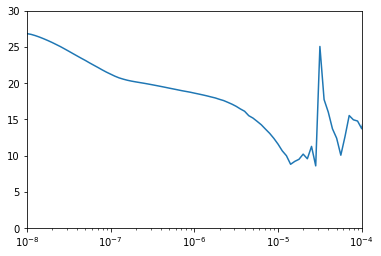

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

In [19]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [21]:
history = model.fit(dataset, epochs=300)

Epoch 1/300
8/8 [==============================] - 1s 10ms/step - loss: 22.6808 - mae: 23.1756
Epoch 2/300
8/8 [==============================] - 0s 8ms/step - loss: 17.0249 - mae: 17.5188
Epoch 3/300
8/8 [==============================] - 0s 8ms/step - loss: 13.3989 - mae: 13.8885
Epoch 4/300
8/8 [==============================] - 0s 8ms/step - loss: 11.6160 - mae: 12.1065
Epoch 5/300
8/8 [==============================] - 0s 8ms/step - loss: 16.7813 - mae: 17.2735
Epoch 6/300
8/8 [==============================] - 0s 8ms/step - loss: 16.1428 - mae: 16.6359
Epoch 7/300
8/8 [==============================] - 0s 8ms/step - loss: 13.0647 - mae: 13.5582
Epoch 8/300
8/8 [==============================] - 0s 8ms/step - loss: 8.8555 - mae: 9.3451
Epoch 9/300
8/8 [==============================] - 0s 8ms/step - loss: 18.0494 - mae: 18.5455
Epoch 10/300
8/8 [==============================] - 0s 8ms/step - loss: 17.8511 - mae: 18.3485
Epoch 11/300
8/8 [==============================] - 0s 8ms/s

8/8 [==============================] - 0s 7ms/step - loss: 5.4465 - mae: 5.9311
Epoch 89/300
8/8 [==============================] - 0s 8ms/step - loss: 4.7028 - mae: 5.1763
Epoch 90/300
8/8 [==============================] - 0s 8ms/step - loss: 4.8152 - mae: 5.2949
Epoch 91/300
8/8 [==============================] - 0s 8ms/step - loss: 4.4770 - mae: 4.9546
Epoch 92/300
8/8 [==============================] - 0s 7ms/step - loss: 4.4925 - mae: 4.9699
Epoch 93/300
8/8 [==============================] - 0s 7ms/step - loss: 6.0960 - mae: 6.5839
Epoch 94/300
8/8 [==============================] - 0s 8ms/step - loss: 5.7892 - mae: 6.2690
Epoch 95/300
8/8 [==============================] - 0s 7ms/step - loss: 7.1444 - mae: 7.6347
Epoch 96/300
8/8 [==============================] - 0s 8ms/step - loss: 6.2044 - mae: 6.6907
Epoch 97/300
8/8 [==============================] - 0s 8ms/step - loss: 5.7905 - mae: 6.2675
Epoch 98/300
8/8 [==============================] - 0s 8ms/step - loss: 5.3522 - ma

8/8 [==============================] - 0s 7ms/step - loss: 5.3173 - mae: 5.7970
Epoch 176/300
8/8 [==============================] - 0s 8ms/step - loss: 4.8493 - mae: 5.3287
Epoch 177/300
8/8 [==============================] - 0s 8ms/step - loss: 4.7980 - mae: 5.2709
Epoch 178/300
8/8 [==============================] - 0s 8ms/step - loss: 5.4246 - mae: 5.9070
Epoch 179/300
8/8 [==============================] - 0s 7ms/step - loss: 5.0499 - mae: 5.5303
Epoch 180/300
8/8 [==============================] - 0s 8ms/step - loss: 5.0326 - mae: 5.5089
Epoch 181/300
8/8 [==============================] - 0s 8ms/step - loss: 4.5125 - mae: 4.9895
Epoch 182/300
8/8 [==============================] - 0s 8ms/step - loss: 4.9886 - mae: 5.4654
Epoch 183/300
8/8 [==============================] - 0s 7ms/step - loss: 4.4275 - mae: 4.9054
Epoch 184/300
8/8 [==============================] - 0s 8ms/step - loss: 4.6011 - mae: 5.0788
Epoch 185/300
8/8 [==============================] - 0s 7ms/step - loss: 4

8/8 [==============================] - 0s 8ms/step - loss: 4.3637 - mae: 4.8382
Epoch 263/300
8/8 [==============================] - 0s 8ms/step - loss: 4.2411 - mae: 4.7134
Epoch 264/300
8/8 [==============================] - 0s 8ms/step - loss: 4.3294 - mae: 4.8052
Epoch 265/300
8/8 [==============================] - 0s 8ms/step - loss: 4.5448 - mae: 5.0201
Epoch 266/300
8/8 [==============================] - 0s 7ms/step - loss: 4.3833 - mae: 4.8592
Epoch 267/300
8/8 [==============================] - 0s 8ms/step - loss: 4.2866 - mae: 4.7554
Epoch 268/300
8/8 [==============================] - 0s 7ms/step - loss: 4.9186 - mae: 5.3977
Epoch 269/300
8/8 [==============================] - 0s 8ms/step - loss: 4.5198 - mae: 4.9979
Epoch 270/300
8/8 [==============================] - 0s 8ms/step - loss: 5.1383 - mae: 5.6172
Epoch 271/300
8/8 [==============================] - 0s 8ms/step - loss: 6.6123 - mae: 7.0920
Epoch 272/300
8/8 [==============================] - 0s 8ms/step - loss: 6

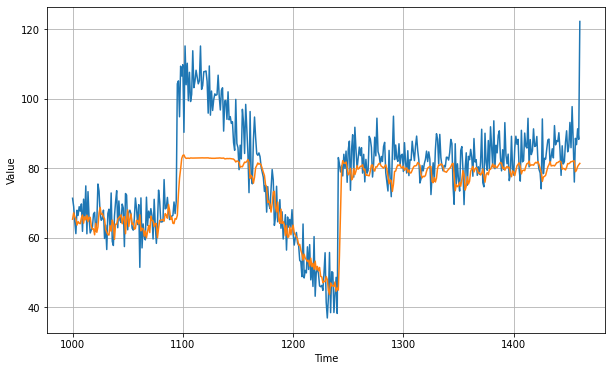

In [22]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.9302044

<Figure size 432x288 with 0 Axes>

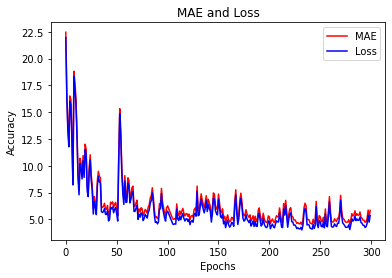

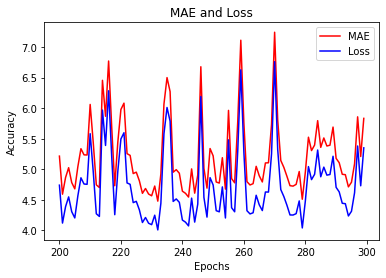

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()